# Credit Card Fraud Detection

## Imports

In [1]:
import pandas as pd
import numpy as np
# import tensorflow as tf
# for tensorflow version 2.0.0 and higher run the code below
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import sklearn
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

Instructions for updating:
non-resource variables are not supported in the long term


## Loading Dataset

In [2]:
# Import and store dataset
credit_card_data = pd.read_csv('creditcard.csv')
credit_card_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Data Prep

In [3]:
# Shuffle and randomize data
shuffled_data = credit_card_data.sample(frac=1)

# Change Class column into Class_0 ([1 0] for legit data) and Class_1 ([0 1] for fraudulent data)
one_hot_data = pd.get_dummies(shuffled_data, columns=['Class'])

# Change all values into numbers between 0 and 1
normalized_data = (one_hot_data - one_hot_data.min()) / (one_hot_data.max() - one_hot_data.min())

# Store just columns V1 through V28 in df_X and columns Class_0 and Class_1 in df_y
df_X = normalized_data.drop(['Class_0', 'Class_1'], axis=1)
df_y = normalized_data[['Class_0', 'Class_1']]

# Convert both data_frames into np arrays of float32
ar_X, ar_y = np.asarray(df_X.values, dtype='float32'), np.asarray(df_y.values, dtype='float32')

# Allocate first 80% of data into training data and remaining 20% into testing data
train_size = int(0.8 * len(ar_X))
(X_train, y_train) = (ar_X[:train_size], ar_y[:train_size])
(X_test, y_test) = (ar_X[train_size:], ar_y[train_size:])

In [4]:
# Gets a percent of fraud vs legit transactions (0.0017% of transactions are fraudulent)
count_legit, count_fraud = np.unique(credit_card_data['Class'], return_counts=True)[1]
fraud_ratio = float(count_fraud / (count_legit + count_fraud))
print('Percent of fraudulent transactions: ', fraud_ratio)

Percent of fraudulent transactions:  0.001727485630620034


In [5]:
# Applies a logit weighting of 578 (1/0.0017) to fraudulent transactions to cause model to pay more attention to them
weighting = 1 / fraud_ratio
y_train[:, 1] = y_train[:, 1] * weighting

In [6]:
# def prepare_mini_batches(data, labels, batch_size):
#     assert len(data) == len(labels)
    
#     all_batches = list()
#     for i in range(0, len(data)):
#         all_batches.append((data[i], labels[i]))
#     random.shuffle(all_batches)
        
#     mini_batches = list()
#     while len(all_batches) >= batch_size:
        
#         data_batch = list()
#         labels_batch = list()
#         for j in range(0, batch_size):
#             data, labels = all_batches.pop()
#             data_batch.append(data)
#             labels_batch.append(labels)
            
#         mini_batches.append((np.array(data_batch), np.array(labels_batch)))
    
#     return mini_batches

In [7]:
# # divide trainX, trainY data into batches of size 128, data is copied
# mini_batches_example = prepare_mini_batches(X_train, y_train, 128)

# # pop next batches
# exampleX_batches, exampleY_batches = mini_batches_example.pop()
# print("Input data mini-batch: " + str(exampleX_batches.shape))
# print("Input data labels mini-batch: " + str(exampleY_batches.shape))

## Neural Networks Prep

In [8]:
# 30 cells for the input
input_dimensions = ar_X.shape[1]

# 2 cells for the output
output_dimensions = ar_y.shape[1]

# 100 cells for the 1st layer
num_layer_1_cells = 100

# 150 cells for the second layer
num_layer_2_cells = 150

In [9]:
# reset tensorflow graph
tf.reset_default_graph()

# We will use these as inputs to the model when it comes time to train it (assign values at run time)
X_train_node = tf.placeholder(tf.float32, [None, input_dimensions], name='X_train')
y_train_node = tf.placeholder(tf.float32, [None, output_dimensions], name='y_train')
learning_rate_ = tf.placeholder(tf.float32, None, name="learning_rate")

# We will use these as inputs to the model once it comes time to test it
X_test_node = tf.constant(X_test, name='X_test')
y_test_node = tf.constant(y_test, name='y_test')

# First layer takes in input and passes output to 2nd layer
weight_1_node = tf.Variable(tf.zeros([input_dimensions, num_layer_1_cells]), name='weight_1')
biases_1_node = tf.Variable(tf.zeros([num_layer_1_cells]), name='biases_1')

# Second layer takes in input from 1st layer and passes output to 3rd layer
weight_2_node = tf.Variable(tf.zeros([num_layer_1_cells, num_layer_2_cells]), name='weight_2')
biases_2_node = tf.Variable(tf.zeros([num_layer_2_cells]), name='biases_2')

# Third layer takes in input from 2nd layer and outputs [1 0] or [0 1] depending on fraud vs legit
weight_3_node = tf.Variable(tf.zeros([num_layer_2_cells, output_dimensions]), name='weight_3')
biases_3_node = tf.Variable(tf.zeros([output_dimensions]), name='biases_3')

In [10]:
#Function to run an input tensor through the 3 layers and output a tensor that will give us a fraud/legit result
# Each layer uses a different function to fit lines through the data and predict whether a given input tensor will \
#   result in a fraudulent or legitimate transaction

def network(input_tensor):
    
    # Sigmoid fits modified data well
    layer1 = tf.nn.sigmoid(tf.matmul(input_tensor, weight_1_node) + biases_1_node)
    
    # Dropout prevents model from becoming lazy and over confident
    layer2 = tf.nn.dropout(tf.nn.sigmoid(tf.matmul(layer1, weight_2_node) + biases_2_node), 0.85)
    
    # Softmax works very well with one hot encoding which is how results are outputted
    layer3 = tf.nn.softmax(tf.matmul(layer2, weight_3_node) + biases_3_node)
    return layer3

In [11]:
#Hyperparameters

epochs = 100
batch_size = 128
learning_rate = 0.005

In [12]:
# Used to predict what results will be given training or testing input data
# Remember, X_train_node is just a placeholder for now. We will enter values at run time
y_train_prediction = network(X_train_node)
y_test_prediction = network(X_test_node)

# Cross entropy loss function measures differences between actual output and predicted output
cross_entropy = tf.losses.softmax_cross_entropy(y_train_node, y_train_prediction)

# Adam optimizer function will try to minimize loss (cross_entropy) but changing the 3 layers' variable values at a
#   learning rate of 0.005
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

# Function to calculate the accuracy of the actual result vs the predicted result
def calculate_accuracy(actual, predicted):
    actual = np.argmax(actual, 1)
    predicted = np.argmax(predicted, 1)
    return (100 * np.sum(np.equal(predicted, actual)) / predicted.shape[0])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Training

In [15]:
info = {'train':[], 'validation':[], 'train_acc':[], 'validation_acc':[]}

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(epochs):
#         mini_batches = prepare_mini_batches(X_train, y_train, batch_size)
        
        epoch_losses = []
        epoch_accuracy = []
        
#         while mini_batches:

#             data_inputs, data_labels = mini_batches.pop()
        
        _, train_loss = session.run([optimizer, cross_entropy],
                                             feed_dict={X_train_node: X_train,
                                                        y_train_node: y_train})

        epoch_y_test, epoch_y_test_prediction = y_test_node.eval(),y_test_prediction.eval()
        train_accuracy = calculate_accuracy(epoch_y_test, epoch_y_test_prediction)

#         epoch_losses.append(batch_loss)
#         epoch_accuracy.append(batch_acc)


#         train_loss = np.mean(epoch_losses)
        info['train'].append(train_loss)

#         train_accuracy = np.mean(epoch_accuracy)
        info['train_acc'].append(train_accuracy)
        
        val_loss = session.run(cross_entropy, feed_dict={X_train_node: X_test, 
                                                              y_train_node: y_test})
        info['validation'].append(val_loss)

        final_y_test, final_y_test_prediction = y_test_node.eval(), y_test_prediction.eval()
        val_accuracy = calculate_accuracy(final_y_test, final_y_test_prediction)
        info['validation_acc'].append(val_accuracy)

        print("Epoch: " + str(epoch + 1) + "/" + str(epochs) + ":\n"
              + "      - Training loss: " + str(train_loss) + " (acc: " + str(train_accuracy) + ")\n"
              + "      - Validation loss: " + str(val_loss) + " (acc: " + str(val_accuracy) + ")")

Epoch: 1/100:
      - Training loss: 1.3805314 (acc: 99.82268881008392)
      - Validation loss: 0.644778 (acc: 99.82268881008392)
Epoch: 2/100:
      - Training loss: 1.3835528 (acc: 0.1773111899160844)
      - Validation loss: 0.77877414 (acc: 0.1773111899160844)
Epoch: 3/100:
      - Training loss: 1.3880665 (acc: 1.077911590182929)
      - Validation loss: 0.7132956 (acc: 0.9954004424001967)
Epoch: 4/100:
      - Training loss: 1.3813956 (acc: 99.82268881008392)
      - Validation loss: 0.6373842 (acc: 99.82268881008392)
Epoch: 5/100:
      - Training loss: 1.3833948 (acc: 99.82268881008392)
      - Validation loss: 0.6309112 (acc: 99.82268881008392)
Epoch: 6/100:
      - Training loss: 1.3836827 (acc: 99.6892665285629)
      - Validation loss: 0.66679054 (acc: 99.6857554158913)
Epoch: 7/100:
      - Training loss: 1.380758 (acc: 1.8345563709139425)
      - Validation loss: 0.71258867 (acc: 1.8538674906077737)
Epoch: 8/100:
      - Training loss: 1.380856 (acc: 0.18082230258769003)

Epoch: 63/100:
      - Training loss: 0.85942996 (acc: 99.40486640216284)
      - Validation loss: 0.3793121 (acc: 99.44173308521471)
Epoch: 64/100:
      - Training loss: 0.85317457 (acc: 99.3205996980443)
      - Validation loss: 0.38248032 (acc: 99.27495523331343)
Epoch: 65/100:
      - Training loss: 0.85329384 (acc: 99.77879990168884)
      - Validation loss: 0.36024085 (acc: 99.77002212000983)
Epoch: 66/100:
      - Training loss: 0.85487103 (acc: 99.84902215512096)
      - Validation loss: 0.34998518 (acc: 99.84199992977774)
Epoch: 67/100:
      - Training loss: 0.84801716 (acc: 99.77353323268143)
      - Validation loss: 0.35651505 (acc: 99.77002212000983)
Epoch: 68/100:
      - Training loss: 0.8472367 (acc: 99.52951090200484)
      - Validation loss: 0.3708092 (acc: 99.51371089498262)
Epoch: 69/100:
      - Training loss: 0.845194 (acc: 99.51722200765423)
      - Validation loss: 0.37017298 (acc: 99.49264421895299)
Epoch: 70/100:
      - Training loss: 0.85095215 (acc: 99.762

## Model Analysis

In [16]:
final_fraud_y_test = final_y_test[final_y_test[:, 1] == 1]
final_fraud_y_test_prediction = final_y_test_prediction[final_y_test[:, 1] == 1]
final_fraud_accuracy = calculate_accuracy(final_fraud_y_test, final_fraud_y_test_prediction)
print('Final fraud specific accuracy: {0:.2f}%'.format(final_fraud_accuracy))

Final fraud specific accuracy: 85.15%


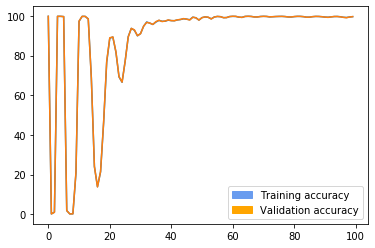

In [23]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(info['train_acc'], label='Training acc')
ax1.plot(info['validation_acc'], label='Validation acc')
blue_patch = mpatches.Patch(color='#699cef', label='Training accuracy')
orange_patch = mpatches.Patch(color='orange', label='Validation accuracy')
ax1.legend(handles=[blue_patch, orange_patch])
plt.show()

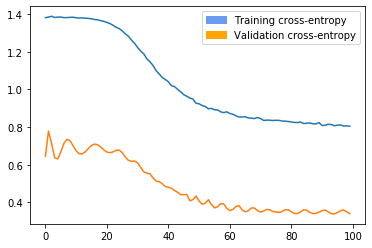

In [18]:
fig1 = plt.figure()
ax2 = fig1.add_subplot(111)
ax2.plot(info['train'], label='Training loss')
ax2.plot(info['validation'], label='Validation loss')
blue_patch = mpatches.Patch(color='#699cef', label='Training cross-entropy')
orange_patch = mpatches.Patch(color='orange', label='Validation cross-entropy')
ax2.legend(handles=[blue_patch, orange_patch])
plt.show()

In [ ]:
session.close()

In [26]:
df = pd.DataFrame(info)

In [27]:
df.head

<bound method NDFrame.head of        train  validation  train_acc  validation_acc
0   1.380531    0.644778  99.822689       99.822689
1   1.383553    0.778774   0.177311        0.177311
2   1.388067    0.713296   1.077912        0.995400
3   1.381396    0.637384  99.822689       99.822689
4   1.383395    0.630911  99.822689       99.822689
..       ...         ...        ...             ...
95  0.810322    0.346244  99.610266       99.569889
96  0.811033    0.356126  99.331133       99.322355
97  0.805404    0.359626  99.232822       99.129244
98  0.806009    0.349862  99.490889       99.475089
99  0.804733    0.340193  99.662933       99.678733

[100 rows x 4 columns]>